# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

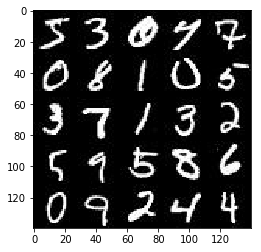

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

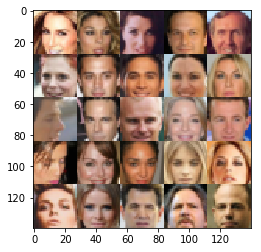

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_ph = tf.placeholder(tf.float32, None, name= 'learn_ph')
    return input_real, input_z,learn_ph

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        layer_one = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid', 
                                     kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_one = tf.maximum(0.1 * layer_one, layer_one)
        # 12x12x64

        layer_two = tf.layers.conv2d(layer_one, 128, 5, strides=2, padding='valid',
                                     kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_two = tf.layers.batch_normalization(layer_two, training=True)
        layer_two = tf.maximum(0.1 * layer_two, layer_two)
        # 4x4x128

        layer_three = tf.layers.conv2d(layer_two, 256, 5, strides=2, padding='same',
                                      kernel_initializer= tf.contrib.layers.xavier_initializer())
        layer_three = tf.layers.batch_normalization(layer_three, training=True)
        layer_three = tf.maximum(0.1 * layer_three, layer_three)
        # 2x2x256

        # Flatten it
        layer_three = tf.nn.dropout(layer_three, 0.9)
        flattened = tf.reshape(layer_three, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        # Fully connected - 4*4*256 output
        layer_one = tf.layers.dense(z, 2*2*256)
        layer_one = tf.reshape(layer_one, (-1, 2, 2, 256))
        layer_one = tf.layers.batch_normalization(layer_one, training=is_train)
        layer_one = tf.maximum(0.01*layer_one, layer_one)

        # Second layer - 14*14*64 output
        layer_two = tf.layers.conv2d_transpose(layer_one, 64, 5, strides=2, padding='VALID')
        layer_two = tf.layers.batch_normalization(layer_two, training=is_train)
        layer_two = tf.maximum(0.01*layer_two, layer_two)
        
        # Third layer - 28*28*32
        layer_three = tf.layers.conv2d_transpose(layer_two, 32, 5, strides=2, padding='SAME')
        layer_three = tf.layers.batch_normalization(layer_three, training=is_train)
        layer_three = tf.maximum(0.01*layer_three, layer_three)

        # Ouput layer - 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer_three, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generated_img = generator(input_z, out_channel_dim, is_train=True)
    tensor_real, logits_real = discriminator(input_real, reuse=False)
    tensor_fake, logits_fake = discriminator(generated_img, reuse=True)
    smooth = 0.09
    
    loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_real, 
                                                labels= tf.ones_like(tensor_real)*(1-smooth)))
    loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake, 
                                                labels=tf.zeros_like(tensor_fake)))
    
    loss_total_d = loss_real + loss_fake
    
    loss_total_g = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake, 
                                                labels=tf.ones_like(tensor_fake)))

    return loss_total_d, loss_total_g

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        train_optimized_d = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                    var_list=d_vars)
        train_optimized_g = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, 
                                                                    var_list=g_vars)

        return train_optimized_d, train_optimized_g
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, learn_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    loss_d, loss_g = model_loss(input_real, input_z, data_shape[3])
    opt_d, opt_g = model_opt(loss_d, loss_g, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(opt_d, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                _ = sess.run(opt_g, feed_dict={input_real: batch_images, input_z: batch_z, learn_ph:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = loss_d.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = loss_g.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 1.2965
Epoch 1/2... Discriminator Loss: 1.6604... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.9152
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.4637... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.4954... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.5297... Generator Loss: 0.6184


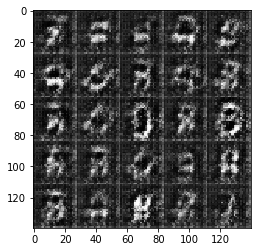

Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.6222
Epoch 1/2... Discriminator Loss: 1.5143... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 0.4403
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.6103
Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.6999... Generator Loss: 0.3592
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.5436... Generator Loss: 0.5849


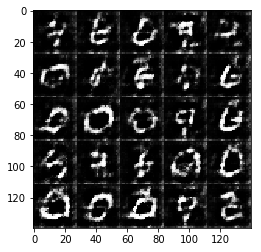

Epoch 1/2... Discriminator Loss: 1.5278... Generator Loss: 0.4960
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.8642
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 1.8129... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.4697
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 1.7189... Generator Loss: 0.3403


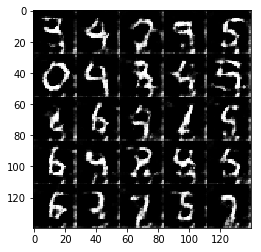

Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.5736... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 1.7290... Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.6645... Generator Loss: 0.5034


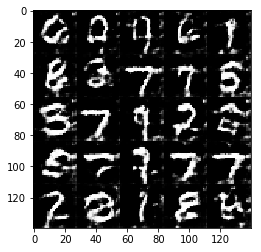

Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.6843... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.9157
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.5886


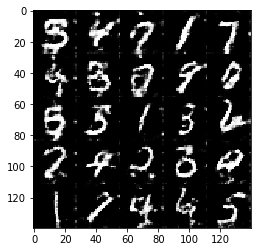

Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.4024
Epoch 1/2... Discriminator Loss: 1.8143... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 1.6732... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.5639
Epoch 1/2... Discriminator Loss: 1.6574... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 2.0638... Generator Loss: 0.2306
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.7270


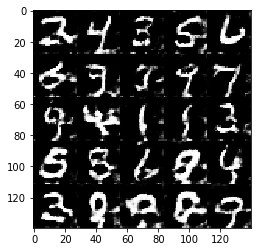

Epoch 1/2... Discriminator Loss: 1.6475... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.7409... Generator Loss: 0.3334
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 1.8870... Generator Loss: 0.2720
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.5396
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.9551... Generator Loss: 0.2166
Epoch 1/2... Discriminator Loss: 2.9716... Generator Loss: 2.3667


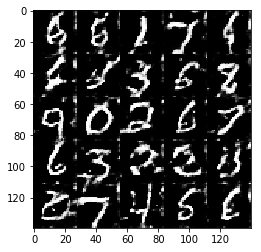

Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.7352... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.3442


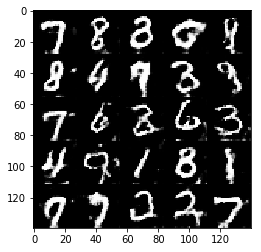

Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.4654
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 2.2421... Generator Loss: 0.1930
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.5726
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 1.7796... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.3904
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.9326


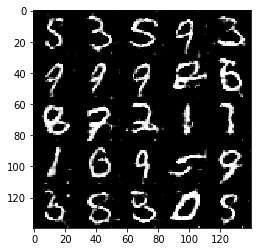

Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 0.2406
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.9665... Generator Loss: 0.2469
Epoch 1/2... Discriminator Loss: 1.4418... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 2.1329... Generator Loss: 0.2054
Epoch 1/2... Discriminator Loss: 2.0092... Generator Loss: 0.2520
Epoch 1/2... Discriminator Loss: 1.5557... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3474


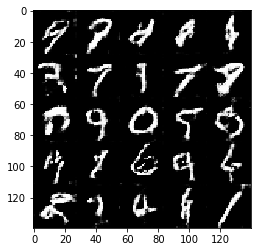

Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.4385
Epoch 1/2... Discriminator Loss: 1.7565... Generator Loss: 0.4176
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.6792
Epoch 1/2... Discriminator Loss: 2.0493... Generator Loss: 0.2430
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.6784... Generator Loss: 0.4057
Epoch 1/2... Discriminator Loss: 1.8570... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 2.1192... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 1.7896... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 1.7806... Generator Loss: 0.3045


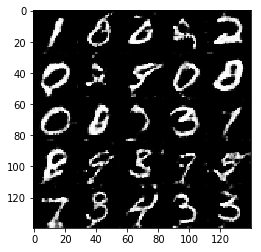

Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.8785
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.6869... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 1.8730... Generator Loss: 0.2617
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 0.3696
Epoch 1/2... Discriminator Loss: 1.9574... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 1.4254... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 2.1856... Generator Loss: 0.1850


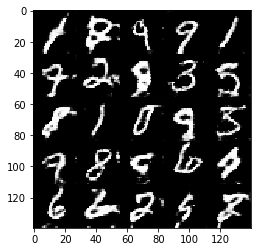

Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.4764... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.8939... Generator Loss: 0.2502
Epoch 1/2... Discriminator Loss: 2.0539... Generator Loss: 0.2723
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 2.0834... Generator Loss: 0.2096
Epoch 1/2... Discriminator Loss: 1.8453... Generator Loss: 0.3184
Epoch 1/2... Discriminator Loss: 1.4839... Generator Loss: 0.5371


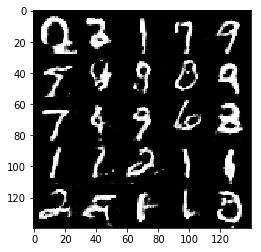

Epoch 1/2... Discriminator Loss: 1.7629... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 1.7988... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.8047... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 2.3772... Generator Loss: 0.1717
Epoch 1/2... Discriminator Loss: 1.6444... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.6920... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.8575... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 2.5270... Generator Loss: 0.1512


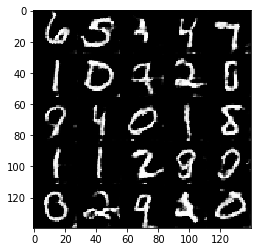

Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.6427... Generator Loss: 1.1275
Epoch 1/2... Discriminator Loss: 1.9437... Generator Loss: 0.2874
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 2.0800... Generator Loss: 0.2222
Epoch 1/2... Discriminator Loss: 1.8463... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 1.8803... Generator Loss: 0.4104
Epoch 1/2... Discriminator Loss: 2.7196... Generator Loss: 0.1351


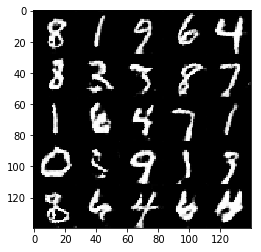

Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 0.3224
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.3261
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3545
Epoch 1/2... Discriminator Loss: 1.4842... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.7470... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.4685
Epoch 1/2... Discriminator Loss: 2.1170... Generator Loss: 0.2471
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 2.2777... Generator Loss: 0.1749
Epoch 1/2... Discriminator Loss: 1.7096... Generator Loss: 0.3595


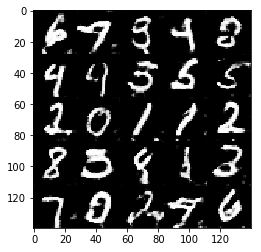

Epoch 1/2... Discriminator Loss: 1.9264... Generator Loss: 0.2962
Epoch 1/2... Discriminator Loss: 1.6407... Generator Loss: 0.3803
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 1.8139... Generator Loss: 0.3576
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.5732
Epoch 1/2... Discriminator Loss: 1.8516... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 1.6780... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.7727... Generator Loss: 0.3771
Epoch 1/2... Discriminator Loss: 2.2107... Generator Loss: 0.1766


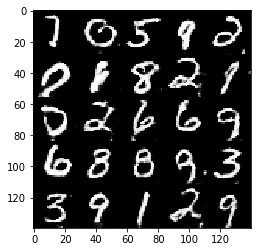

Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.6711... Generator Loss: 1.6993
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.5676... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.6998... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.8319... Generator Loss: 0.2900
Epoch 1/2... Discriminator Loss: 1.7237... Generator Loss: 0.4619
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.6595


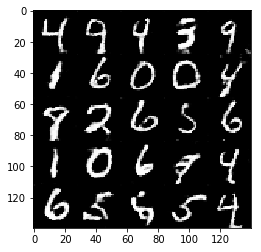

Epoch 1/2... Discriminator Loss: 1.9240... Generator Loss: 0.3686
Epoch 1/2... Discriminator Loss: 1.9456... Generator Loss: 0.2760
Epoch 1/2... Discriminator Loss: 2.3835... Generator Loss: 0.1719
Epoch 1/2... Discriminator Loss: 1.8356... Generator Loss: 0.3138
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 2.3901... Generator Loss: 0.1728
Epoch 1/2... Discriminator Loss: 2.2930... Generator Loss: 0.2044
Epoch 2/2... Discriminator Loss: 1.8984... Generator Loss: 0.4270
Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 2.4299... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.7690... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.6773... Generator Loss: 0.3668
Epoch 2/2... Discriminator Loss: 2.0127... Generator Loss: 0.2675
Epoch 2/2... Discriminator Loss: 1.6396... Generator Loss: 0.3963
Epoch 2/2.

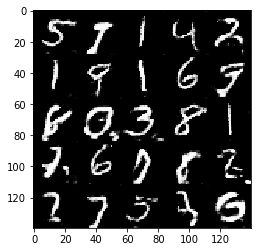

Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.9309... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 2.0176... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 2.0731... Generator Loss: 0.2313
Epoch 2/2... Discriminator Loss: 1.6804... Generator Loss: 0.3968
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.5266
Epoch 2/2... Discriminator Loss: 1.8488... Generator Loss: 0.3384


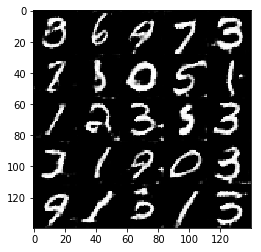

Epoch 2/2... Discriminator Loss: 3.1247... Generator Loss: 0.0986
Epoch 2/2... Discriminator Loss: 1.6792... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.7793... Generator Loss: 0.2844
Epoch 2/2... Discriminator Loss: 1.6158... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.8590... Generator Loss: 0.4406
Epoch 2/2... Discriminator Loss: 1.7802... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 2.0140... Generator Loss: 0.3023


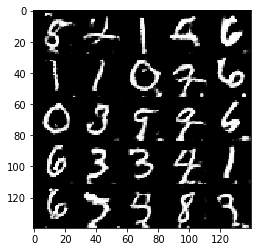

Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.5731... Generator Loss: 0.4320
Epoch 2/2... Discriminator Loss: 2.0583... Generator Loss: 0.2704
Epoch 2/2... Discriminator Loss: 2.1663... Generator Loss: 0.2332
Epoch 2/2... Discriminator Loss: 1.8863... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.7528... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.8851... Generator Loss: 0.3921
Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 1.5968... Generator Loss: 0.4463
Epoch 2/2... Discriminator Loss: 1.6499... Generator Loss: 0.3572


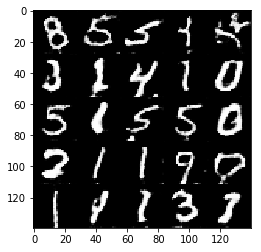

Epoch 2/2... Discriminator Loss: 1.7868... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.4720
Epoch 2/2... Discriminator Loss: 2.6615... Generator Loss: 0.1251
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 1.8821... Generator Loss: 0.2335
Epoch 2/2... Discriminator Loss: 2.5651... Generator Loss: 0.1502
Epoch 2/2... Discriminator Loss: 1.6442... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 2.8865... Generator Loss: 0.1117
Epoch 2/2... Discriminator Loss: 2.4845... Generator Loss: 0.1775


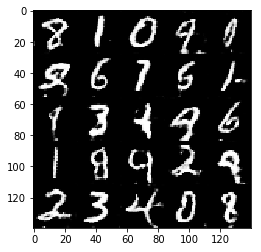

Epoch 2/2... Discriminator Loss: 2.6768... Generator Loss: 0.1240
Epoch 2/2... Discriminator Loss: 1.7019... Generator Loss: 0.3822
Epoch 2/2... Discriminator Loss: 1.9537... Generator Loss: 0.3052
Epoch 2/2... Discriminator Loss: 2.6605... Generator Loss: 0.1349
Epoch 2/2... Discriminator Loss: 1.7452... Generator Loss: 0.3881
Epoch 2/2... Discriminator Loss: 2.2728... Generator Loss: 0.3057
Epoch 2/2... Discriminator Loss: 2.1720... Generator Loss: 0.2035
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 1.5784... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.9049... Generator Loss: 0.2724


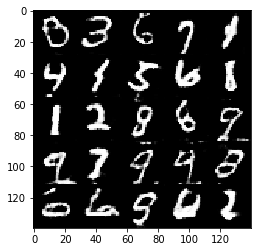

Epoch 2/2... Discriminator Loss: 1.8388... Generator Loss: 0.3107
Epoch 2/2... Discriminator Loss: 2.8865... Generator Loss: 0.1187
Epoch 2/2... Discriminator Loss: 2.1026... Generator Loss: 0.3000
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 0.5147
Epoch 2/2... Discriminator Loss: 2.0803... Generator Loss: 0.2837
Epoch 2/2... Discriminator Loss: 2.0197... Generator Loss: 0.2991
Epoch 2/2... Discriminator Loss: 1.7745... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.7150... Generator Loss: 0.3949
Epoch 2/2... Discriminator Loss: 1.9943... Generator Loss: 0.2834
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7325


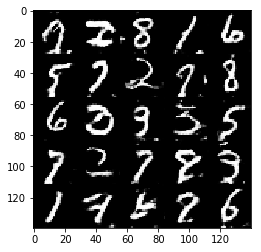

Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.7213... Generator Loss: 0.3887
Epoch 2/2... Discriminator Loss: 2.7263... Generator Loss: 0.1530
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 2.5076... Generator Loss: 0.1621
Epoch 2/2... Discriminator Loss: 1.0153... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 2.2347... Generator Loss: 0.1938
Epoch 2/2... Discriminator Loss: 1.8789... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 2.2839... Generator Loss: 0.2252
Epoch 2/2... Discriminator Loss: 3.1542... Generator Loss: 0.0783


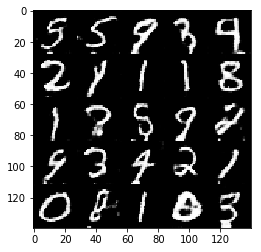

Epoch 2/2... Discriminator Loss: 2.0580... Generator Loss: 0.2475
Epoch 2/2... Discriminator Loss: 3.0752... Generator Loss: 0.0890
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 1.8194... Generator Loss: 0.3136
Epoch 2/2... Discriminator Loss: 1.6552... Generator Loss: 0.3835
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.6511... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 2.5833... Generator Loss: 0.1397
Epoch 2/2... Discriminator Loss: 1.5789... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 1.9822... Generator Loss: 0.2641


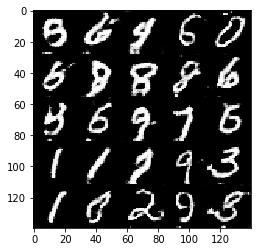

Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 2.8514... Generator Loss: 0.1129
Epoch 2/2... Discriminator Loss: 1.6653... Generator Loss: 0.4071
Epoch 2/2... Discriminator Loss: 2.1711... Generator Loss: 0.2427
Epoch 2/2... Discriminator Loss: 1.6679... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 2.2003... Generator Loss: 0.2111
Epoch 2/2... Discriminator Loss: 3.1880... Generator Loss: 0.0987
Epoch 2/2... Discriminator Loss: 1.6975... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 2.1993... Generator Loss: 0.1838
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.5628


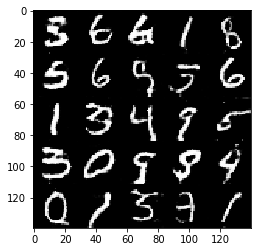

Epoch 2/2... Discriminator Loss: 2.1071... Generator Loss: 0.2033
Epoch 2/2... Discriminator Loss: 1.7598... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.7304... Generator Loss: 0.3215
Epoch 2/2... Discriminator Loss: 1.8752... Generator Loss: 0.3846
Epoch 2/2... Discriminator Loss: 2.7667... Generator Loss: 0.1174
Epoch 2/2... Discriminator Loss: 2.3522... Generator Loss: 0.2044
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.9954... Generator Loss: 0.3309
Epoch 2/2... Discriminator Loss: 2.2315... Generator Loss: 0.2181
Epoch 2/2... Discriminator Loss: 1.8837... Generator Loss: 0.2757


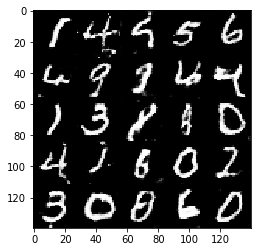

Epoch 2/2... Discriminator Loss: 2.1009... Generator Loss: 0.2437
Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 2.4935... Generator Loss: 0.1628
Epoch 2/2... Discriminator Loss: 2.6322... Generator Loss: 0.1655
Epoch 2/2... Discriminator Loss: 1.9308... Generator Loss: 0.3442
Epoch 2/2... Discriminator Loss: 1.4630... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 2.6090... Generator Loss: 0.1801
Epoch 2/2... Discriminator Loss: 1.6376... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 2.0670... Generator Loss: 2.2405


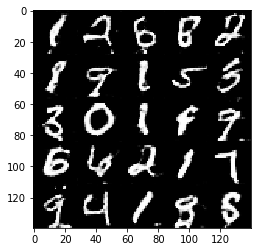

Epoch 2/2... Discriminator Loss: 1.9503... Generator Loss: 0.3120
Epoch 2/2... Discriminator Loss: 1.6018... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 2.4252... Generator Loss: 0.1856
Epoch 2/2... Discriminator Loss: 2.0613... Generator Loss: 0.2585
Epoch 2/2... Discriminator Loss: 2.5161... Generator Loss: 0.2456
Epoch 2/2... Discriminator Loss: 2.4363... Generator Loss: 0.1685
Epoch 2/2... Discriminator Loss: 1.5810... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 1.7977... Generator Loss: 0.4533
Epoch 2/2... Discriminator Loss: 1.9742... Generator Loss: 0.3391
Epoch 2/2... Discriminator Loss: 2.5646... Generator Loss: 0.2222


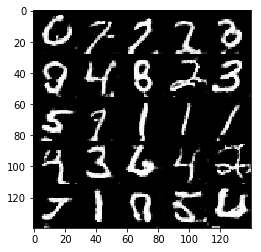

Epoch 2/2... Discriminator Loss: 2.5675... Generator Loss: 2.3652
Epoch 2/2... Discriminator Loss: 2.1903... Generator Loss: 0.2031
Epoch 2/2... Discriminator Loss: 1.9709... Generator Loss: 0.3288
Epoch 2/2... Discriminator Loss: 2.2840... Generator Loss: 0.3233
Epoch 2/2... Discriminator Loss: 1.8913... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 2.9195... Generator Loss: 0.1072
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.5146... Generator Loss: 0.5191
Epoch 2/2... Discriminator Loss: 1.4523... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.8263... Generator Loss: 0.3851


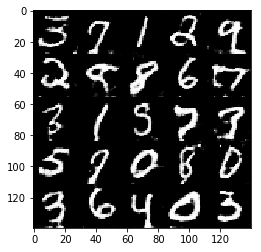

Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 2.2657... Generator Loss: 0.1933
Epoch 2/2... Discriminator Loss: 1.8157... Generator Loss: 0.4057
Epoch 2/2... Discriminator Loss: 2.4583... Generator Loss: 0.1751
Epoch 2/2... Discriminator Loss: 2.2917... Generator Loss: 0.2016
Epoch 2/2... Discriminator Loss: 2.6075... Generator Loss: 0.1516
Epoch 2/2... Discriminator Loss: 2.8037... Generator Loss: 0.1018
Epoch 2/2... Discriminator Loss: 2.2323... Generator Loss: 0.1744
Epoch 2/2... Discriminator Loss: 1.7187... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 1.4087... Generator Loss: 0.7308


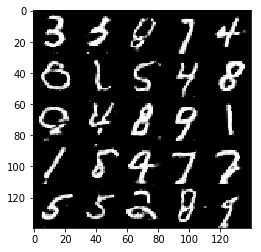

Epoch 2/2... Discriminator Loss: 3.8106... Generator Loss: 0.0710
Epoch 2/2... Discriminator Loss: 1.5394... Generator Loss: 0.4787
Epoch 2/2... Discriminator Loss: 2.3429... Generator Loss: 0.1937
Epoch 2/2... Discriminator Loss: 2.2306... Generator Loss: 0.2396
Epoch 2/2... Discriminator Loss: 2.0074... Generator Loss: 0.3177
Epoch 2/2... Discriminator Loss: 1.9764... Generator Loss: 0.2330
Epoch 2/2... Discriminator Loss: 1.7820... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 2.5548... Generator Loss: 0.1767
Epoch 2/2... Discriminator Loss: 2.4539... Generator Loss: 0.2085
Epoch 2/2... Discriminator Loss: 2.0146... Generator Loss: 0.2646


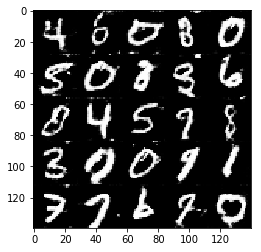

Epoch 2/2... Discriminator Loss: 3.0426... Generator Loss: 0.1078
Epoch 2/2... Discriminator Loss: 3.2722... Generator Loss: 0.0737
Epoch 2/2... Discriminator Loss: 2.1184... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 1.8840... Generator Loss: 0.3619
Epoch 2/2... Discriminator Loss: 2.2367... Generator Loss: 0.2358
Epoch 2/2... Discriminator Loss: 2.9969... Generator Loss: 0.1008
Epoch 2/2... Discriminator Loss: 2.9479... Generator Loss: 0.1104
Epoch 2/2... Discriminator Loss: 1.9469... Generator Loss: 0.3877
Epoch 2/2... Discriminator Loss: 3.4141... Generator Loss: 0.0963
Epoch 2/2... Discriminator Loss: 1.8110... Generator Loss: 0.3807


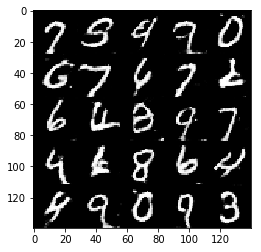

Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 1.6632
Epoch 2/2... Discriminator Loss: 1.5442... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.9032... Generator Loss: 0.2938
Epoch 2/2... Discriminator Loss: 1.7282... Generator Loss: 0.4082
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 2.4284... Generator Loss: 0.2318
Epoch 2/2... Discriminator Loss: 2.3243... Generator Loss: 0.2572
Epoch 2/2... Discriminator Loss: 1.9956... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.8671... Generator Loss: 0.3877
Epoch 2/2... Discriminator Loss: 1.8597... Generator Loss: 0.3663


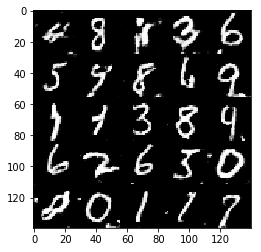

Epoch 2/2... Discriminator Loss: 2.1629... Generator Loss: 0.3166
Epoch 2/2... Discriminator Loss: 2.7101... Generator Loss: 0.1327
Epoch 2/2... Discriminator Loss: 1.5236... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 2.0019... Generator Loss: 0.2976
Epoch 2/2... Discriminator Loss: 2.9467... Generator Loss: 0.1054
Epoch 2/2... Discriminator Loss: 3.2061... Generator Loss: 0.0865
Epoch 2/2... Discriminator Loss: 2.7830... Generator Loss: 0.1661


In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.8412... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.6020... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6405


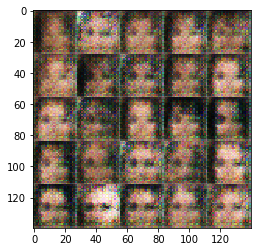

Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6600


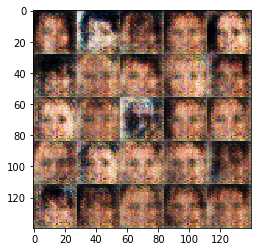

Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 1.0381


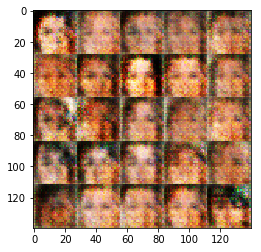

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7251


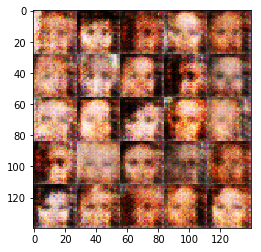

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6151


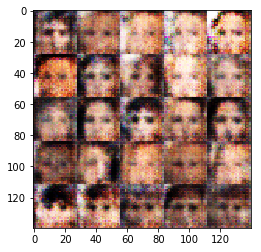

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8998


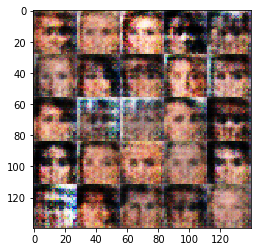

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8717


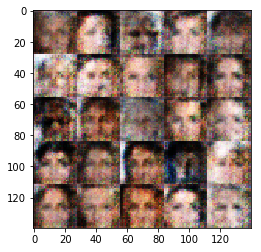

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6655


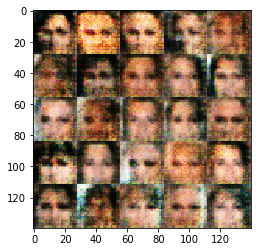

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7910


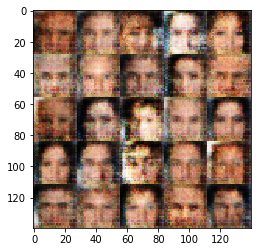

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5998


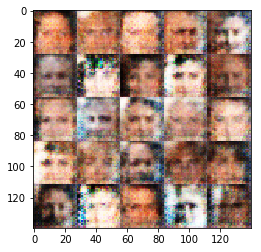

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8187


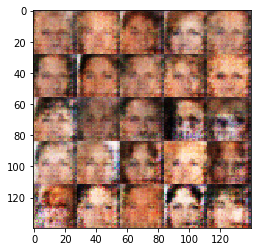

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8169


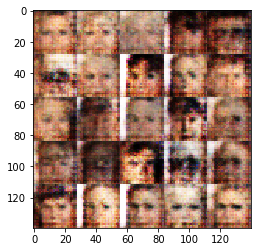

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7298


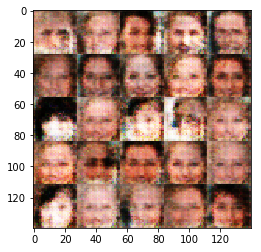

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5543


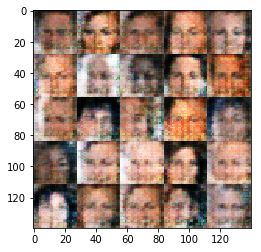

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6507


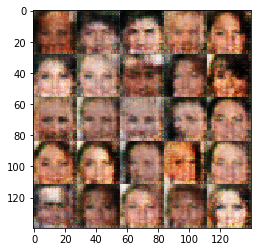

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8608


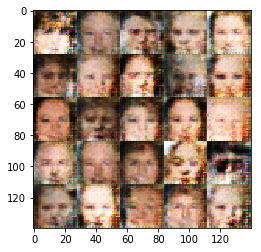

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7596


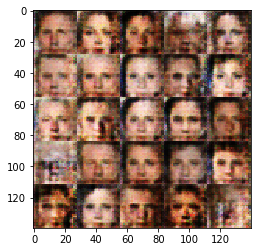

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8267


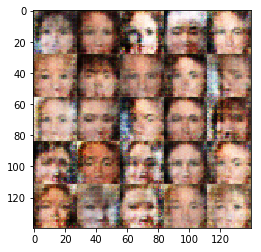

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8381


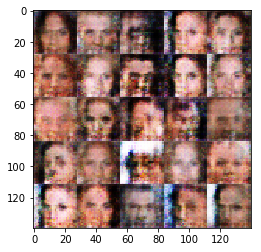

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7774


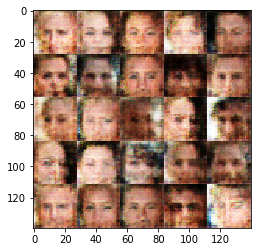

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6498


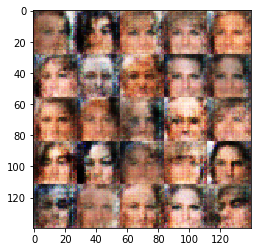

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7619


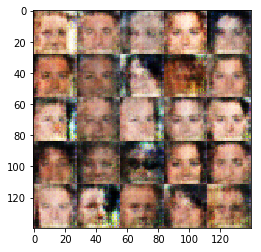

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8343


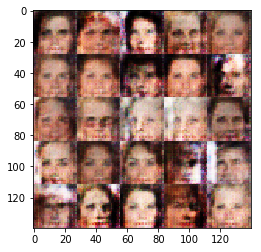

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8709


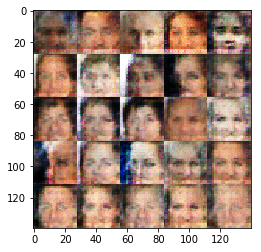

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7900


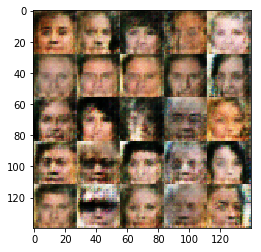

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7374


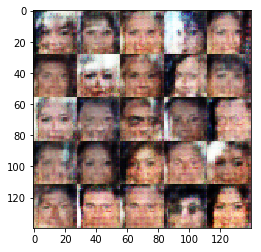

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7789


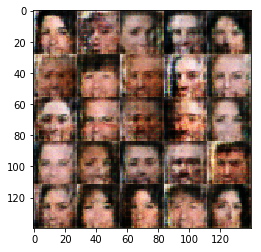

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7359


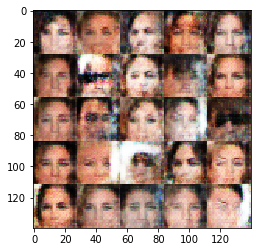

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7192


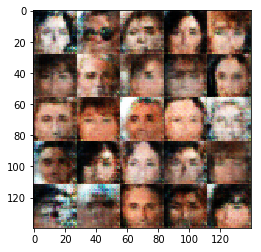

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7388


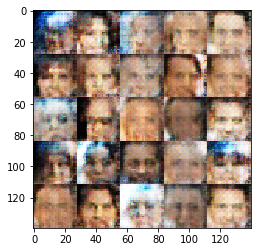

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7547


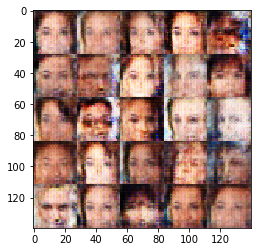

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6809


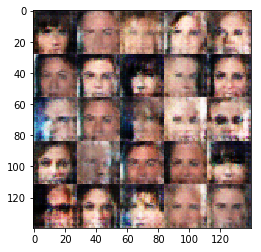

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7779


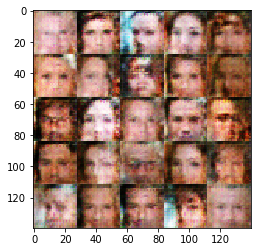

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7732


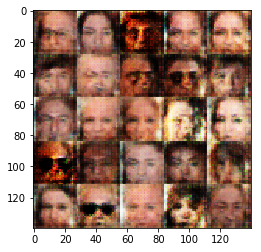

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7573


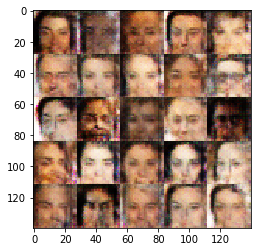

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8954


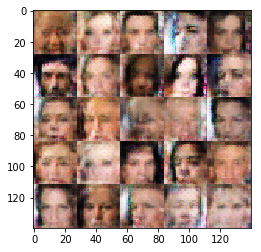

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7993


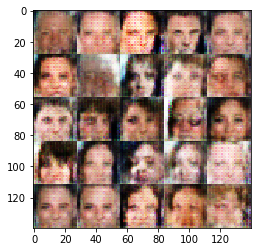

Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8459


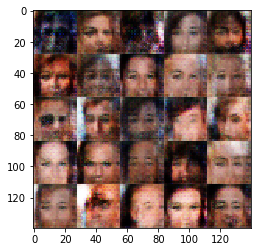

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7619


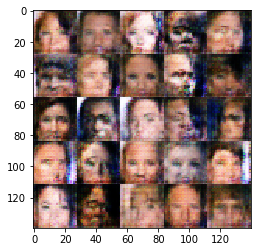

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7912


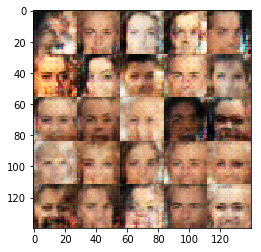

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7718


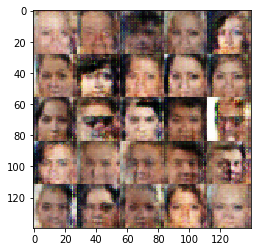

Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7910


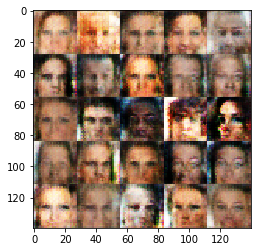

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8951


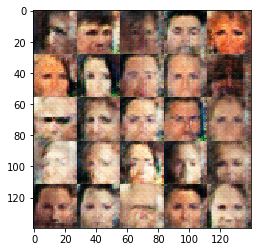

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7805


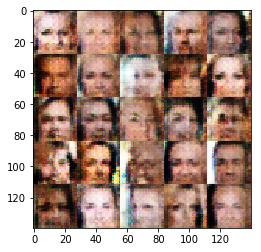

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7411


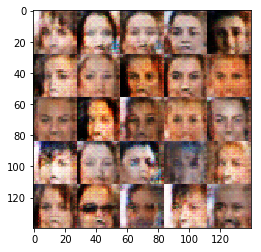

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7882


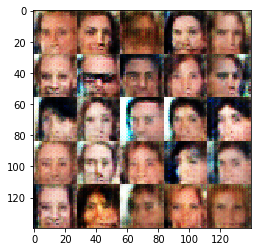

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7726


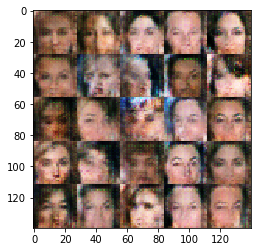

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8085


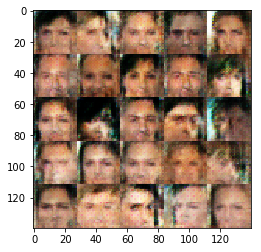

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7991


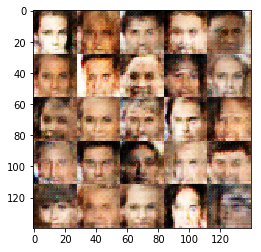

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7558


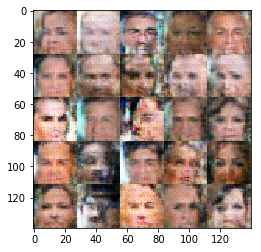

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7546


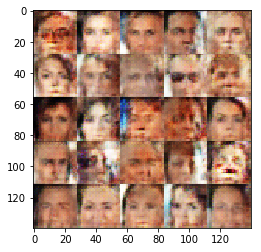

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7838


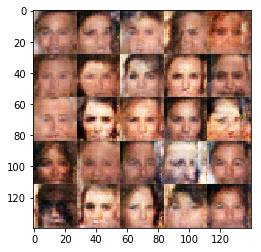

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7916


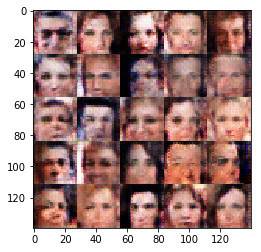

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8745


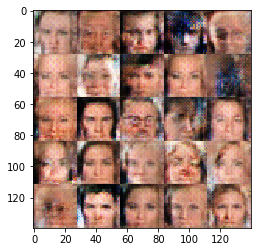

Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8327


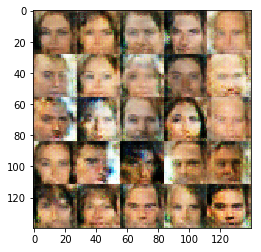

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7894


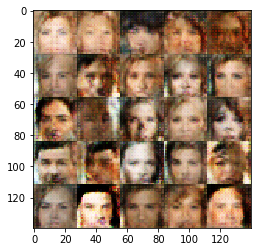

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8425


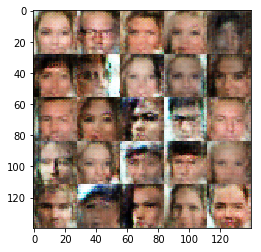

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7615


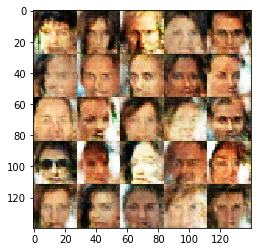

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7872


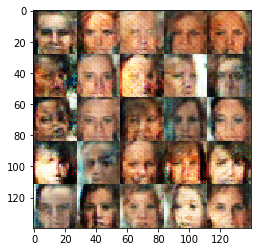

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7947


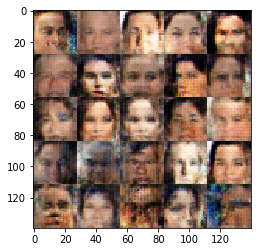

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7602


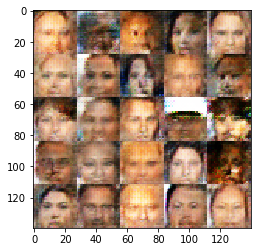

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7256


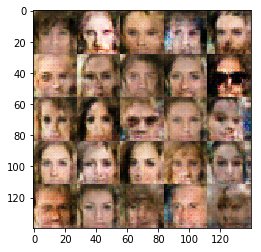

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7466


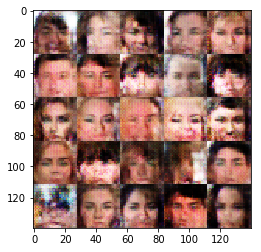

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7901


In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.